<a href="https://colab.research.google.com/github/AbigailMRod/GANsDL.AI/blob/main/StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Componentes de StyleGAN

En este cuaderno, se implementarán varios componentes de StyleGAN, incluido el truco de truncamiento, la capa de mapeo, la inyección de ruido, la normalización de instancia adaptativa (AdaIN) y el crecimiento progresivo.



## Empezando
Comenzará importando algunos paquetes de PyTorch y definiendo una función de visualización que será útil más adelante.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Función de visualización de imágenes: Dado un tensor de imágenes, número de imágenes,
     tamaño por imagen e imágenes por fila, traza e imprime las imágenes en una cuadrícula uniforme.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, padding=0)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

## Truco de truncamiento
El primer componente que implementará es el truco de truncamiento. Recuerde que esto se hace después de entrenar al modelo y cuando está muestreando hermosos resultados. El truco de truncamiento vuelve a muestrear el vector de ruido $z$ a partir de una distribución normal truncada que le permite ajustar la fidelidad/diversidad del generador. El valor de truncamiento es al menos 0, donde 1 significa que hay poco truncamiento (alta diversidad) y 0 significa que la distribución está truncada excepto la media (alta calidad/fidelidad). Este truco no es exclusivo de StyleGAN. 

In [6]:
from scipy.stats import truncnorm
def get_truncated_noise(n_samples, z_dim, truncation):
    '''
    Función para crear vectores de ruido truncados: Dadas las dimensiones (n_samples, z_dim)
     y el valor de truncamiento, crea un tensor de esa forma lleno de aleatorio
     números de la distribución normal truncada.
     Parámetros:
         n_samples: el número de muestras a generar, un escalar
         z_dim: la dimensión del vector de ruido, un escalar
         truncation: el valor de truncamiento, un escalar no negativo
    '''
    #### START CODE HERE ####
    truncated_noise = truncnorm.rvs(-truncation, truncation, size=(n_samples, z_dim))
    #### END CODE HERE ####
    return torch.Tensor(truncated_noise)

In [3]:
# Probar la muestra de truncamiento
assert tuple(get_truncated_noise(n_samples=10, z_dim=5, truncation=0.7).shape) == (10, 5)
simple_noise = get_truncated_noise(n_samples=1000, z_dim=10, truncation=0.2)
assert simple_noise.max() > 0.199 and simple_noise.max() < 2
assert simple_noise.min() < -0.199 and simple_noise.min() > -0.2
assert simple_noise.std() > 0.113 and simple_noise.std() < 0.117
print("Success!")

Success!


## Asignación de $z$ → $w$

El siguiente componente que debe implementar es la red de mapeo. Toma el vector de ruido, $z$, y lo asigna a un vector de ruido intermedio, $w$. Esto hace que $z$ se pueda representar en un espacio más desenredado, lo que hace que las funciones sean más fáciles de controlar más adelante.

La red de mapeo en StyleGAN está compuesta por 8 capas, pero para su implementación, utilizará una red neuronal con 3 capas. Esto es para ahorrar tiempo entrenando más tarde.

In [5]:
class MappingLayers(nn.Module):
    '''
    Clase de capas de mapeo
     Valores:
         z_dim: la dimensión del vector de ruido, un escalar
         hidden_dim: la dimensión interna, un escalar
         w_dim: la dimensión del vector de ruido intermedio, un escalar
    '''
 
    def __init__(self, z_dim, hidden_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            # Escriba una red neuronal que admita tensores de
             # forma (n_muestras, z_dim) y salidas (n_muestras, w_dim)
             # con una capa oculta con neuronas hidden_dim
            #### START CODE HERE ####
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, w_dim)
            #### END CODE HERE ####
        )

    def forward(self, noise):
        '''
        Función para completar un pase hacia adelante de MappingLayers:
         Dado un tensor de ruido inicial, devuelve el tensor de ruido intermedio.
         Parámetros:
             noise: un tensor de ruido con dimensiones (n_samples, z_dim)
        '''
        return self.mapping(noise)
    
    def get_mapping(self):
        return self.mapping

In [7]:
# Test the mapping function
map_fn = MappingLayers(10,20,30)
assert tuple(map_fn(torch.randn(2, 10)).shape) == (2, 30)
assert len(map_fn.mapping) > 4
outputs = map_fn(torch.randn(1000, 10))
assert outputs.std() > 0.05 and outputs.std() < 0.3
assert outputs.min() > -2 and outputs.min() < 0
assert outputs.max() < 2 and outputs.max() > 0
layers = [str(x).replace(' ', '').replace('inplace=True', '') for x in map_fn.get_mapping()]
assert layers == ['Linear(in_features=10,out_features=20,bias=True)', 
                  'ReLU()', 
                  'Linear(in_features=20,out_features=20,bias=True)', 
                  'ReLU()', 
                  'Linear(in_features=20,out_features=30,bias=True)']
print("Success!")

Success!


## Inyección de ruido aleatorio
A continuación, implementará la inyección de ruido aleatorio que se produce antes de cada bloque AdaIN. Para hacer esto, debe crear un tensor de ruido que tenga el mismo tamaño que el mapa de características actual (imagen).

El tensor de ruido no es del todo aleatorio; se inicializa como un canal aleatorio que luego se multiplica por pesos aprendidos para cada canal en la imagen. Por ejemplo, imagine que una imagen tiene 512 canales y su alto y ancho son (4 x 4). Primero crearía una matriz de ruido aleatoria (4 x 4) con un canal. Luego, su modelo crearía 512 valores, uno para cada canal. Luego, multiplicas la matriz (4 x 4) por cada uno de estos valores. Esto crea un tensor "aleatorio" de 512 canales y (4 x 4) píxeles, las mismas dimensiones que la imagen. Finalmente, agrega este tensor de ruido a la imagen. Esto introduce ruido no correlacionado y pretende aumentar la diversidad en la imagen.

Se generan nuevos pesos iniciales para cada nueva capa, o generador, donde se usa esta clase. Dentro de una capa, cada vez que se llama a la inyección de ruido, da otro paso con el optimizador y los pesos que usa para cada canal se optimizan (es decir, se aprenden).

In [8]:
class InjectNoise(nn.Module):
    '''
    Inyectar clase de ruido
     Valores:
         chanels: el número de canales que tiene la imagen, un escalar
    '''
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter( # Usas nn.Parameter para que estos pesos puedan ser optimizados
             # Iniciar los pesos para los canales a partir de una distribución normal aleatoria
            #### START CODE HERE ####
            torch.randn(1, channels, 1, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Función para completar un pase hacia adelante de InjectNoise: Dada una imagen,
         devuelve la imagen con ruido aleatorio añadido.
         Parámetros:
             image: el mapa de características de la forma (n_samples, canales, ancho, alto)
        '''
        
        #### START CODE HERE ####
        noise_shape = (image.shape[0], 1, image.shape[2], image.shape[3])
        #### END CODE HERE ####
        
        noise = torch.randn(noise_shape, device=image.device) # Creates the random noise
        return image + self.weight * noise #Se aplica a la imagen después de multiplicar por el peso de cada canal
    
    def get_weight(self):
        return self.weight

    def get_self(self):
        return self

In [9]:
# UNIT TEST
test_noise_channels = 3000
test_noise_samples = 20
fake_images = torch.randn(test_noise_samples, test_noise_channels, 10, 10)
inject_noise = InjectNoise(test_noise_channels)
assert torch.abs(inject_noise.weight.std() - 1) < 0.1
assert torch.abs(inject_noise.weight.mean()) < 0.1
assert type(inject_noise.get_weight()) == torch.nn.parameter.Parameter

assert tuple(inject_noise.weight.shape) == (1, test_noise_channels, 1, 1)
inject_noise.weight = nn.Parameter(torch.ones_like(inject_noise.weight))
# Check that something changed
assert torch.abs((inject_noise(fake_images) - fake_images)).mean() > 0.1
# Check that the change is per-channel
assert torch.abs((inject_noise(fake_images) - fake_images).std(0)).mean() > 1e-4
assert torch.abs((inject_noise(fake_images) - fake_images).std(1)).mean() < 1e-4
assert torch.abs((inject_noise(fake_images) - fake_images).std(2)).mean() > 1e-4
assert torch.abs((inject_noise(fake_images) - fake_images).std(3)).mean() > 1e-4
# Check that the per-channel change is roughly normal
per_channel_change = (inject_noise(fake_images) - fake_images).mean(1).std()
assert per_channel_change > 0.9 and per_channel_change < 1.1
# Make sure that the weights are being used at all
inject_noise.weight = nn.Parameter(torch.zeros_like(inject_noise.weight))
assert torch.abs((inject_noise(fake_images) - fake_images)).mean() < 1e-4
assert len(inject_noise.weight.shape) == 4
print("Success!")

Success!


## Normalización de instancia adaptable (AdaIN)
El siguiente componente que implementará es AdaIN. Para aumentar el control sobre la imagen, inyecta $w$, el vector de ruido intermedio, varias veces en StyleGAN. Esto se hace transformándolo en un conjunto de parámetros de estilo e introduciendo el estilo a la imagen a través de AdaIN. Dada una imagen ($x_i$) y el vector intermedio ($w$), AdaIN toma la normalización de instancia de la imagen y la multiplica por la escala de estilo ($y_s$) y agrega el sesgo de estilo ($y_b$). Debe calcular la escala de estilo aprendible y el sesgo mediante el uso de asignaciones lineales de $w$.

# $ \text{AdaIN}(\boldsymbol{\mathrm{x}}_i, \boldsymbol{\mathrm{y}}) = \boldsymbol{\mathrm{y}}_{s,i} \frac{\boldsymbol {\mathrm{x}}_i - \mu(\boldsymbol{\mathrm{x}}_i)}{\sigma(\boldsymbol{\mathrm{x}}_i)} + \boldsymbol{\mathrm{y}} _ {b, i} $

In [10]:
class AdaIN(nn.Module):
    '''
    Clase AdaIN
     Valores:
         chanels: el número de canales que tiene la imagen, un escalar
         w_dim: la dimensión del vector de ruido intermedio, un escalar
    '''

    def __init__(self, channels, w_dim):
        super().__init__()

        # Normalize the input per-dimension
        self.instance_norm = nn.InstanceNorm2d(channels)

        # Desea asignar w a un conjunto de pesos de estilo por canal.
         # Reemplace los Ningunos con las dimensiones correctas - tenga en cuenta que
         # ambos mapas lineales transforman un vector w en pesos de estilo
         # correspondiente al número de canales de imagen.
        #### START CODE HERE ####
        self.style_scale_transform = nn.Linear(w_dim, channels)
        self.style_shift_transform = nn.Linear(w_dim, channels)
        #### END CODE HERE ####

    def forward(self, image, w):
        '''
        Función para completar un pase hacia adelante de AdaIN: Dada una imagen y un vector de ruido intermedio w,
         devuelve la imagen normalizada que ha sido escalada y desplazada por el estilo.
         Parámetros:
             image: el mapa de características de la forma (n_samples, canales, ancho, alto)
             w: el vector de ruido intermedio
        '''
        normalized_image = self.instance_norm(image)
        style_scale = self.style_scale_transform(w)[:, :, None, None]
        style_shift = self.style_shift_transform(w)[:, :, None, None]
        
        # Calculate the transformed image
        #### START CODE HERE ####
        transformed_image = style_scale * normalized_image + style_shift
        #### END CODE HERE ####
        return transformed_image
    
    def get_style_scale_transform(self):
        return self.style_scale_transform
    
    def get_style_shift_transform(self):
        return self.style_shift_transform
    
    def get_self(self):
        return self 


In [11]:
w_channels = 50
image_channels = 20
image_size = 30
n_test = 10
adain = AdaIN(image_channels, w_channels)
test_w = torch.randn(n_test, w_channels)
assert adain.style_scale_transform(test_w).shape == adain.style_shift_transform(test_w).shape
assert adain.style_scale_transform(test_w).shape[-1] == image_channels
assert tuple(adain(torch.randn(n_test, image_channels, image_size, image_size), test_w).shape) == (n_test, image_channels, image_size, image_size)

w_channels = 3
image_channels = 2
image_size = 3
n_test = 1
adain = AdaIN(image_channels, w_channels)

adain.style_scale_transform.weight.data = torch.ones_like(adain.style_scale_transform.weight.data) / 4
adain.style_scale_transform.bias.data = torch.zeros_like(adain.style_scale_transform.bias.data)
adain.style_shift_transform.weight.data = torch.ones_like(adain.style_shift_transform.weight.data) / 5
adain.style_shift_transform.bias.data = torch.zeros_like(adain.style_shift_transform.bias.data)
test_input = torch.ones(n_test, image_channels, image_size, image_size)
test_input[:, :, 0] = 0
test_w = torch.ones(n_test, w_channels)
test_output = adain(test_input, test_w)
assert(torch.abs(test_output[0, 0, 0, 0] - 3 / 5 + torch.sqrt(torch.tensor(9 / 8))) < 1e-4)
assert(torch.abs(test_output[0, 0, 1, 0] - 3 / 5 - torch.sqrt(torch.tensor(9 / 32))) < 1e-4)
print("Success!")

Success!


## Crecimiento progresivo en StyleGAN
El componente StyleGAN final que creará es un crecimiento progresivo. Esto ayuda a StyleGAN a crear imágenes de alta resolución al duplicar gradualmente el tamaño de la imagen hasta el tamaño deseado.

Comenzará creando un bloque para el generador StyleGAN. Este se compone de una capa de muestreo superior, una capa convolucional, una inyección de ruido aleatorio, una capa AdaIN y una activación.

In [12]:
class MicroStyleGANGeneratorBlock(nn.Module):
    '''
    Clase de bloque generador Micro StyleGAN
     Valores:
         in_chan: el número de canales en la entrada, un escalar
         out_chan: el número de canales deseados en la salida, un escalar
         w_dim: la dimensión del vector de ruido intermedio, un escalar
         kernel_size: el tamaño del núcleo convolutivo
         starting_size: el tamaño de la imagen inicial
    '''

    def __init__(self, in_chan, out_chan, w_dim, kernel_size, starting_size, use_upsample=True):
        super().__init__()
        self.use_upsample = use_upsample
        # Reemplace los Ningunos para:
         # 1. Aumentar la muestra al tamaño inicial, de forma bilineal (https://pytorch.org/docs/master/generated/torch.nn.Upsample.html)
         # 2. Cree una convolución kernel_size que tome
         # una imagen con in_chan y genera una con out_chan (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
         # 3. Crea un objeto para inyectar ruido
         # 4. Crea un objeto AdaIN
         # 5. Crea una activación LeakyReLU con pendiente 0.2
        
        #### START CODE HERE ####
        if self.use_upsample:
            self.upsample = nn.Upsample((starting_size, starting_size), mode='bilinear')
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size, padding=1) # Padding is used to maintain the image size
        self.inject_noise = InjectNoise(out_chan)
        self.adain = AdaIN(out_chan, w_dim)
        self.activation = nn.LeakyReLU(0.2)
        #### END CODE HERE ####

    def forward(self, x, w):
        '''
        Función para completar un pase hacia adelante de MicroStyleGANGeneratorBlock: Dada una x y una w,
         calcula un bloque generador de StyleGAN.
         Parámetros:
             x: la entrada en el generador, mapa de características de forma (n_muestras, canales, ancho, alto)
             w: el vector de ruido intermedio
        '''
        if self.use_upsample:
            x = self.upsample(x)
        x = self.conv(x)
        x = self.inject_noise(x)
        x = self.adain(x, w)
        x = self.activation(x)
        return x

    def get_self(self):
        return self;

In [13]:
test_stylegan_block = MicroStyleGANGeneratorBlock(in_chan=128, out_chan=64, w_dim=256, kernel_size=3, starting_size=8)
test_x = torch.ones(1, 128, 4, 4)
test_x[:, :, 1:3, 1:3] = 0
test_w = torch.ones(1, 256)
test_x = test_stylegan_block.upsample(test_x)
assert tuple(test_x.shape) == (1, 128, 8, 8)
assert torch.abs(test_x.mean() - 0.75) < 1e-4
test_x = test_stylegan_block.conv(test_x)
assert tuple(test_x.shape) == (1, 64, 8, 8)
test_x = test_stylegan_block.inject_noise(test_x)
test_x = test_stylegan_block.activation(test_x)
assert test_x.min() < 0
assert -test_x.min() / test_x.max() < 0.4
test_x = test_stylegan_block.adain(test_x, test_w) 
foo = test_stylegan_block(torch.ones(10, 128, 4, 4), torch.ones(10, 256))

print("Success!")

Success!


Ahora, puedes implementar el crecimiento progresivo.

StyleGAN comienza con un tensor constante de 4 x 4 (x 512 canales) que se somete a una iteración del generador sin sobremuestreo. La salida es algo de ruido que luego se puede transformar en una imagen borrosa de 4 x 4. Aquí es donde comienza el proceso de crecimiento progresivo. El ruido de 4 x 4 se puede pasar más a través de un bloque generador con sobremuestreo para producir una salida de 8 x 8. Sin embargo, esto se hará gradualmente.

Simulará el crecimiento progresivo de una imagen de 8 x 8 a una imagen de 16 x 16. En lugar de simplemente pasarlo al bloque del generador con sobremuestreo, StyleGAN entrena gradualmente al generador al nuevo tamaño mezclando una imagen que solo fue sobremuestreada. Al mezclar una imagen de 8 x 8 sobremuestreada (que es de 16 x 16) con una cantidad cada vez mayor de la salida del generador de 16 x 16, el generador es más estable a medida que se entrena progresivamente. Como tal, hará dos operaciones separadas con el ruido de 8 x 8:

1. Páselo al siguiente bloque generador para crear un ruido de salida, que luego transformará en una imagen.
2. Transfórmalo en una imagen y luego haz una muestra de 16 x 16.

Ahora tendrá dos imágenes que tienen el doble de resolución que el ruido de 8 x 8. Luego, utilizando un término alfa ($\alfa$), combina las imágenes de mayor resolución obtenidas de (1) y (2). Luego pasaría esto al discriminador y usaría la retroalimentación para actualizar los pesos de su generador. La clave aquí es que el término $\alpha$ se incrementa gradualmente hasta que, eventualmente, solo se usa la imagen de (1), el generador. Esa es su imagen final o puede continuar este proceso para hacer una imagen de 32 x 32 o 64 x 64, 128 x 128, etc.

Este micromodelo que implementará visualizará lo que genera el modelo en una etapa particular de capacitación, por un valor específico de $\alpha$. Sin embargo, para reiterar, en la práctica, StyleGAN eliminará gradualmente la imagen muestreada aumentando el parámetro $\alpha$ en muchos pasos de entrenamiento, haciendo este proceso repetidamente con valores alfa cada vez más grandes hasta que sea 1; en este punto, la imagen combinada se compone únicamente de la imagen del bloque generador. Este método de entrenamiento gradual del generador aumenta la estabilidad y la fidelidad del modelo.

<!-- pasando un vector de ruido aleatorio en $z$ a través de la función de mapeo que escribiste para obtener $w$. Luego se pasa $w$ a través del primer bloque del generador para crear su primer ruido de salida. -->

In [14]:
class MicroStyleGANGenerator(nn.Module):
    '''
    Clase de generador Micro StyleGAN
     Valores:
         z_dim: la dimensión del vector de ruido, un escalar
         map_hidden_dim: la dimensión interna del mapeo, un escalar
         w_dim: la dimensión del vector de ruido intermedio, un escalar
         in_chan: la dimensión de la entrada constante, generalmente w_dim, un escalar
         out_chan: el número de canales deseados en la salida, un escalar
         kernel_size: el tamaño del núcleo convolutivo
         hidden_chan: la dimensión interna, un escalar
    '''

    def __init__(self, 
                 z_dim, 
                 map_hidden_dim,
                 w_dim,
                 in_chan,
                 out_chan, 
                 kernel_size, 
                 hidden_chan):
        super().__init__()
        self.map = MappingLayers(z_dim, map_hidden_dim, w_dim)
        # Por lo general, esta constante se inicia a todos, pero iniciará a un
         # Gaussiano para visualizar mejor el efecto de la red
        self.starting_constant = nn.Parameter(torch.randn(1, in_chan, 4, 4))
        self.block0 = MicroStyleGANGeneratorBlock(in_chan, hidden_chan, w_dim, kernel_size, 4, use_upsample=False)
        self.block1 = MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 8)
        self.block2 = MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 16)
        # Debe tener una forma de mapear desde el ruido de salida a una imagen,
         # para que aprenda una convolución 1x1 para transformar p. 512 canales en 3 canales
         # (Tenga en cuenta que esto está simplificado, con recorte utilizado en el StyleGAN real)
        self.block1_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.block2_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.alpha = 0.2

    def upsample_to_match_size(self, smaller_image, bigger_image):
        '''
        Función para sobremuestrear una imagen al tamaño de otra: dadas dos imágenes (más pequeña y más grande),
         sobremuestrea el primero para que tenga las mismas dimensiones que el segundo.
         Parámetros:
             small_image: la imagen más pequeña para aumentar la muestra
             bigger_image: la imagen más grande cuyas dimensiones se muestrearán para
        '''
        return F.interpolate(smaller_image, size=bigger_image.shape[-2:], mode='bilinear')

    def forward(self, noise, return_intermediate=False):
        '''
        Función para completar un pase hacia adelante de MicroStyleGANGenerator: Dado el ruido,
         calcula una iteración de StyleGAN.
         Parámetros:
             ruido: un tensor de ruido con dimensiones (n_samples, z_dim)
             return_intermediate: un valor booleano, verdadero para devolver las imágenes también (para pruebas) y falso en caso contrario
        '''
        x = self.starting_constant
        w = self.map(noise)
        x = self.block0(x, w)
        x_small = self.block1(x, w) # First generator run output
        x_small_image = self.block1_to_image(x_small)
        x_big = self.block2(x_small, w) # Second generator run output 
        x_big_image = self.block2_to_image(x_big)
        x_small_upsample = self.upsample_to_match_size(x_small_image, x_big_image) # Aumente la muestra de la salida de ejecución del primer generador para que tenga el mismo tamaño que la salida de ejecución del segundo generador
         # Interpolar entre la imagen muestreada y la imagen del generador usando alfa
        
        #### START CODE HERE ####
        interpolation = self.alpha * x_big_image + (1 - self.alpha) * x_small_upsample
        #### END CODE HERE #### 
        
        if return_intermediate:
            return interpolation, x_small_upsample, x_big_image
        return interpolation
 
    def get_self(self):
        return self;

In [15]:
z_dim = 128
out_chan = 3
truncation = 0.7

mu_stylegan = MicroStyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=1024,
    w_dim=496,
    in_chan=512,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=256
)

test_samples = 10
test_result = mu_stylegan(get_truncated_noise(test_samples, z_dim, truncation))

# Check if the block works
assert tuple(test_result.shape) == (test_samples, out_chan, 16, 16)

# Check that the interpolation is correct
mu_stylegan.alpha = 1.
test_result, _, test_big =  mu_stylegan(
    get_truncated_noise(test_samples, z_dim, truncation), 
    return_intermediate=True)
assert torch.abs(test_result - test_big).mean() < 0.001
mu_stylegan.alpha = 0.
test_result, test_small, _ =  mu_stylegan(
    get_truncated_noise(test_samples, z_dim, truncation), 
    return_intermediate=True)
assert torch.abs(test_result - test_small).mean() < 0.001
print("Success!")

Success!


## Estilo de carreraGAN
¡Finalmente, puede juntar todos los componentes para ejecutar una iteración de su micro StyleGAN!

También puede visualizar lo que puede producir este generador iniciado aleatoriamente. El código se interpolará automáticamente entre diferentes valores de alfa para que pueda ver intuitivamente lo que significa mezclar las imágenes de baja y alta resolución usando diferentes valores de alfa. En la imagen generada, las muestras parten de valores alfa bajos y van a valores alfa altos.

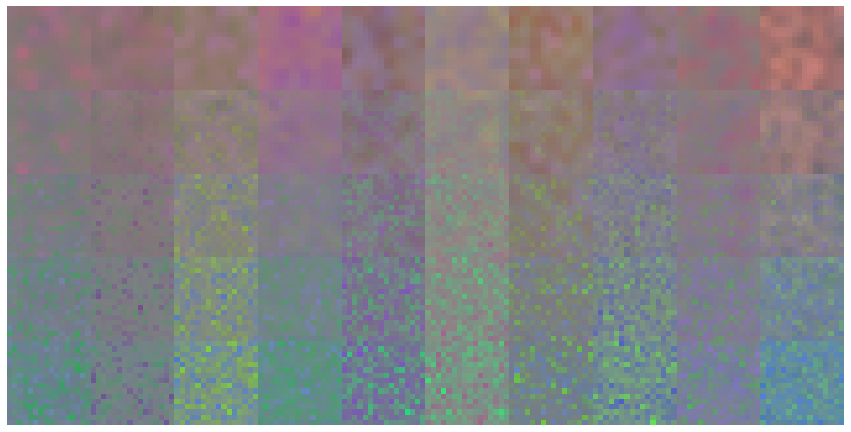

In [16]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

viz_samples = 10
# The noise is exaggerated for visual effect
viz_noise = get_truncated_noise(viz_samples, z_dim, truncation) * 10

mu_stylegan.eval()
images = []
for alpha in np.linspace(0, 1, num=5):
    mu_stylegan.alpha = alpha
    viz_result, _, _ =  mu_stylegan(
        viz_noise, 
        return_intermediate=True)
    images += [tensor for tensor in viz_result]
show_tensor_images(torch.stack(images), nrow=viz_samples, num_images=len(images))
mu_stylegan = mu_stylegan.train()